# Zero Truncated Tucker Poisson Factorization model
## 1. Poisson Factorization
### 定義
Poisson Factorizationは確率的行列分解の誤差項をポアソン分布に拡張したモデルで$i$をユーザー、$j$をアイテムとした場合、 非負値の応答変数$y_{i,j}$と$k次元$の潜在ベクトル$\theta_{ik}$と$\theta_{jk}$の間に以下のような関係があります。

\begin{equation}
y_{ij} \sim Poisson(\sum_{k}\theta_{ik}\theta_{jk})\tag{1}
\end{equation}

### 生成過程
Poisson Factorizationの生成過程は潜在ベクトルの事前分布にガンマ分布を仮定することでパラメータに非負制約にすることができます。
  
1. For each user $i$ and latent component $k$:
\begin{equation}
\theta_{ik} \sim Gamma(a_{user},b_{user})
\end{equation}
  
2. For each item $j$ and latent component $k$:
\begin{equation}
\theta_{jk} \sim Gamma(a_{item},b_{item})
\end{equation}
  
3. For each user $i$ and item $j$, sampling response:
\begin{equation}
y_{ij} \sim Poisson(\sum_{k}\theta_{ik}\theta_{jk})
\end{equation}

### ポアソン分布の共役事前分布のおさらい
ポアソン分布はガンマ分布が共役事前分布であることが知られています。ベイズモデルでのポアソン分布のパラメータの事後分布は以下の解析解が得られることが知られています。
  
\begin{equation}
\begin{split}
p(\lambda|y) \propto p(\lambda)p(\bf y|\lambda) &= \frac{b^{a}}{\Gamma(a)}\lambda^{a-1}e^{-b\lambda} \times \frac{e^{-n\lambda}\lambda^{\sum_{i=1}^{n}y_{i}}}{\prod_{i=1}^{n}y_{i}!}\\
&\propto \lambda^{n\bar{y}+a-1}e^{-(b+n)\lambda}
\end{split}
\end{equation}  
  
ただし、$p(\lambda)$はガンマ事前分布、$p(\bf y|\lambda)$はポアソン分布の尤度関数です。  
また$a$、$b$はガンマ分布のパラメータ、$\lambda$はポアソン分布のパラメータ、$\bf y$は$n$個の観測値です。  
結局ポアソン-ガンマ分布の事後分布は  

\begin{equation}
p(\lambda|y) \sim Gamma(n\bar{y}+a-1,b+n)\tag{2}
\end{equation}

となります。(1)のパラメータは(2)を利用して事後分布を推定することができます。

## 2. シミュレーションデータの生成
### Tucker Decomposition
$\lambda$はより一般的な行列分解の構造であるTucker Decompositionで定式化します。

\begin{equation}
\lambda_{ijk} = \sum_{r=1}^{R}\sum_{s=1}^{S}\sum_{t=1}^{T}\omega_{rst}\theta_{ir}\theta_{js}\theta_{kt} \tag{3}
\end{equation}

ただし、$R$、$S$、$T$はそれぞれのモードの潜在変数のベクトル数で、$\theta$に加え、コアテンソル$\omega$もガンマ分布に従いパラメータが生成されます。  
そして$\lambda$の期待値構造からポアソン分布に従いデータが生成されます。

\begin{equation}
y_{ijk} \sim Poisson(\lambda_{ijk}) 
\end{equation}

以下のコードでシミュレーションデータの生成を行います。

In [1]:
# ライブラリの読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import scipy
from scipy import stats
from scipy import special
from scipy import sparse
from pandas.tools.plotting import scatter_matrix
from numpy.random import *

#np.random.seed(98537)

In [2]:
# 多項分布の乱数を生成する関数
def rmnom(pr, n, k, no):
    z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
    Z = sparse.coo_matrix((np.repeat(1, n), (no, np.array(z_id))), shape=(n, k))   #スパース行列の設定
    return Z

# 切断ポアソン分布の乱数を生成するための関数
def rtpois(value, n, lower):
    k = np.repeat(lower, n)
    z = np.repeat(1, n)
    mu = np.exp(-value)
    t = (mu / (1 - mu)) * value
    s = t.copy()
    u = np.random.uniform(0, 1, n)

    while True:
        z = s < u
        index = np.where(z==True)[0]
        if index.shape[0]==0:
            break    
        k[index] = k[index] + z[index]
        t[index] = t[index] * value[index] / k[index]
        s[index] = s[index] + t[index]
    return k

### a. 入力データの生成

In [3]:
##データの設定
type_n = 3   #モード数
k1 = 12
k2 = 10
k3 = 7
hh = 5000   #モード1のサンプル数
item = 3000   #モード2のサンプル数
context = 100   #モード3のサンプル数
Lambda = np.random.gamma(100.0, 1/0.2, hh)
pt0 = np.random.poisson(Lambda, hh)   #モードあたりのレコード数
N0 = np.sum(pt0)
vec_k1 = np.repeat(1, k1); vec_k2 = np.repeat(1, k2); vec_k3 = np.repeat(1, k3)

In [4]:
##IDとインデックスを作成
#IDの作成
d_id0 = np.repeat(np.arange(hh), pt0)
pt_id0 = np.array(list(itertools.chain(*[np.array(range(pt0[i]), dtype="int") for i in range(hh)])))

# インデックスの設定
index = np.array(range(N0))
d_list0 = [i for i in range(hh)]
for i in range(hh):
    d_list0[i] = index[d_id0==i]

In [5]:
##アイテムの割当を生成
#トピック割当を生成
topic = 25
phi1 = np.random.dirichlet(np.repeat(0.5, item), topic)
theta1 = np.random.dirichlet(np.repeat(0.5, topic), hh)
z1 = np.dot(np.array([np.random.multinomial(1, theta1[i, :], 1) for i in range(hh)]).reshape(hh, topic), range(topic))

#多項分布からアイテムを生成
item_id0 = np.zeros(N0, dtype='int')
for i in range(hh):
    if i%1000==0:
        print(i)
    item_id0[d_list0[i]] = np.dot(np.random.multinomial(1, phi1[z1[i], :], pt0[i]), range(item))
item_dt0 = sparse.coo_matrix((np.repeat(1, N0), (item_id0, range(N0))), shape=(item, N0)).tocsr()   #スパース行列の設定
item_n0 = np.array(np.sum(item_dt0, axis=1)).reshape(-1)

0
1000
2000
3000
4000


In [6]:
##コンテキストの割当を生成
#トピック割当を生成
topic = 15
phi2 = np.random.dirichlet(np.repeat(0.25, context), topic)
theta2 = np.random.dirichlet(np.repeat(0.25, topic), hh)
z2 = np.dot(np.array([np.random.multinomial(1, theta2[i, :], 1) for i in range(hh)]).reshape(hh, topic), range(topic))

#多項分布からアイテムを生成
context_id0 = np.zeros(N0, dtype='int')
for i in range(hh):
    if i%1000==0:
        print(i)
    context_id0[d_list0[i]] = np.dot(np.random.multinomial(1, phi2[z2[i], :], pt0[i]), range(context))
context_dt0 = sparse.coo_matrix((np.repeat(1, N0), (context_id0, range(N0))), shape=(context, N0)).tocsr()   #スパース行列の設定
context_n0 = np.array(np.sum(context_dt0, axis=1)).reshape(-1)

0
1000
2000
3000
4000


### b. 学習データの応答変数の生成
実データの応答変数$y$は欠損で$y > 0$の値しか取得できないことが多いため、0以外の値を学習データに用いる。  
もし、$y = 0$が含まれているデータを欠損として扱わずに学習データに加えるとパラメータの推定値に偏りが生じてしまいます。

In [7]:
rp = 0
while True:
    rp = rp + 1
    
    ##パラメータを生成
    #ガンマ分布のパラメータ
    alpha_u = 0.2; beta_u = 0.7
    alpha_v = 0.2; beta_v = 0.7
    alpha_c = 0.15; beta_c = 0.75
    alpha_r = 0.1; beta_r = 1.0
    
    #ガンマ分布から行列分解のパラメータを生成
    theta_u = np.random.gamma(alpha_u, 1/beta_u, hh*k1).reshape(hh, k1)
    theta_v = np.random.gamma(alpha_v, 1/beta_v, item*k2).reshape(item, k2)
    theta_c = np.random.gamma(alpha_c, 1/beta_c, context*k3).reshape(context, k3)
    omega = np.random.gamma(alpha_r, 1/beta_r, k1*k2*k3).reshape(k1, k2, k3)
    thetat_u = theta_u.copy(); thetat_v = theta_v.copy(); thetat_c = theta_c.copy(); omegat = omega.copy()

    ##ポアソン分布から応答変数を生成
    #タッカー分解の期待値
    mu = np.repeat(0.0, N0)
    theta_vec2 = theta_v[item_id0, ]
    theta_vec3 = theta_c[context_id0, ]
    for j in range(k3):
        mu += np.dot(np.dot(theta_u, omega[:, :, j])[d_id0, ] * theta_vec2 * theta_vec3[:, j][:, np.newaxis], vec_k2)

    #応答変数を生成
    y0 = np.random.poisson(mu, N0)
    
    #break条件
    print(np.array([rp, np.max(y0), np.sum(y0 > 0)]))
    if (np.max(y0) < 300) & (np.max(y0) > 75):
        break

[      1     231 1159179]


In [8]:
##学習対象データのみを取得
#y > 0以上の応答変数のみ取得
index_y = np.array(np.where(y0 > 0)[0], dtype="int")
y1 = y0[index_y]
d_id1 = d_id0[index_y]
item_id1 = item_id0[index_y]
context_id1 = context_id0[index_y]
hhpt = index_y.shape[0]

#インデックスを作成
d_list1 = [i for i in range(hh)]
item_list1 = [i for i in range(hh)]
context_list1 = [i for i in range(hh)]
pt1 = np.repeat(0, hh)
item_n1 = np.repeat(0, item)
context_n1 = np.repeat(0, context)
for i in range(hh):
    d_list1[i] = np.array(np.where(d_id1==i)[0], dtype="int")
    pt1[i] = d_list1[i].shape[0]
for i in range(item):
    item_list1[i] = np.array(np.where(item_id1==i)[0], dtype="int")
    item_n1[i] = item_list1[i].shape[0]
for i in range(context):
    context_list1[i] = np.array(np.where(context_id1==i)[0], dtype="int")
    context_n1[i] = context_list1[i].shape[0]
del y0, d_id0, item_id0, context_id0, d_list0

In [9]:
pd.DataFrame({"y": y1, "d_id": d_id1, "item_id": item_id1, "context_id": context_id1})

,y,d_id,item_id,context_id
0,2,0,1163,13
1,6,0,267,73
2,5,0,386,73
3,4,0,403,13
4,2,0,1268,73
5,3,0,2488,26
6,4,0,783,86
7,1,0,1331,13
8,3,0,1379,50
9,3,0,2168,50


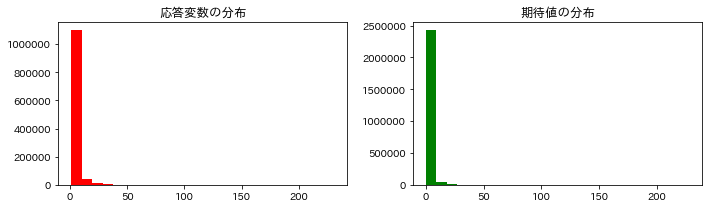

In [10]:
#生成したデータを可視化
dt = [y1, mu]
fig_range = np.append(np.array([np.min(y1), np.min(mu)]), 
                      np.array([np.max(y1), np.max(mu)])).reshape(2, len(dt))
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = ["応答変数の分布", "期待値の分布"]
fig = plt.figure(figsize=(10.0, 3.0))
for j in range(len(dt)):
    ax = fig.add_subplot(1, 2, j+1)
    ax.hist(dt[j],  bins=25, range=(fig_range[0, j], fig_range[1, j]), color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

### c. テストデータの応答変数の生成
b.で生成した学習データは$y > 0$のみが含まれています。テストデータで生成するデータは$y = 0$のデータと$y > 0$の両方が含まれていますが、    
しかし実データでは欠損して、$y = 0$の扱いになっているため、学習データで推定したパラメータを用いてテストデータの欠損を予測します。

In [11]:
##モードごとのIDを作成
#データの設定
pt0 = np.random.poisson(Lambda/2.0, hh)   #ユーザーあたりのレコード数
N0 = np.sum(pt0)

#ユーザーIDを作成
d_id0 = np.repeat(np.arange(hh), pt0)
d_list0 = [i for i in range(hh)]
for i in range(hh):
    d_list0[i] = np.array(np.where(d_id0==i)[0], dtype="int")

#アイテムIDを作成
item_id0 = np.zeros(N0, dtype='int')
for i in range(hh):
    item_id0[d_list0[i]] = np.dot(np.random.multinomial(1, phi1[z1[i], :], pt0[i]), range(item))
    
#コンテキストIDを作成
context_id0 = np.zeros(N0, dtype='int')
for i in range(hh):
    context_id0[d_list0[i]] = np.dot(np.random.multinomial(1, phi2[z2[i], :], pt0[i]), range(context))
    
#学習データと重複があるIDを除く
id1 = pd.DataFrame({"d_id": d_id1, "item_id": item_id1, "context_id": context_id1, "flag": 1})
id2 = pd.DataFrame({"d_id": d_id0, "item_id": item_id0, "context_id": context_id0, "flag": 2})
joint_id = pd.concat((id1, id2), axis=0)
index_target = np.array(np.where((joint_id.iloc[:, :type_n].duplicated()==False) & (joint_id["flag"]==2))[0], dtype="int")
d_id2 = np.array(joint_id["d_id"].iloc[index_target])
item_id2 = np.array(joint_id["item_id"].iloc[index_target])
context_id2 = np.array(joint_id["context_id"].iloc[index_target])
N = index_target.shape[0]

In [12]:
##ポアソン分布から応答変数を生成
#タッカー分解の期待値
mu = np.repeat(0.0, N)
theta_vec2 = thetat_v[item_id2, ]
theta_vec3 = thetat_c[context_id2, ]
for j in range(k3):
    mu += np.dot(np.dot(thetat_u, omegat[:, :, j])[d_id2, ] * theta_vec2 * theta_vec3[:, j][:, np.newaxis], vec_k2)

#応答変数を生成
y2 = np.random.poisson(mu, N)
y_vec2 = y2[:, np.newaxis]

## 3. ギブスサンプリングによるPoisson Factorizationの推定
### 概要
### 特徴ベクトルのサンプリング
特徴ベクトル$\bf \theta$は事前分布がガンマ分布、尤度関数がポアソン分布なので、共役性があり事後分布はガンマ分布に従います。
しかし(3)の形式とはなりませんので、Tucker Decompositionのパラメータと期待値が全て非負の値を取るという性質を利用して特徴ベクトルの条件付き事後分布を計算することができます。  
そのために以下の補助変数を導入します。  
Tucker Decompositionの期待値は

\begin{equation}
\lambda_{ijk} = \sum_{r=1}^{R}\sum_{s=1}^{S}\sum_{t=1}^{T}\omega_{rst}\theta_{ir}\theta_{js}\theta_{kt}
\end{equation}

となり、$\theta_{ir}$の補助変数$\kappa_{ijk}^{r}$は

\begin{equation}
\kappa_{ijk}^{r} \rm = \frac{\sum_{s=1}^{S}\sum_{t=1}^{T}\omega_{rst}\theta_{ir}\theta_{js}\theta_{kt}}{\lambda_{ijk}} \tag{4}
\end{equation}

です。$\sum_{r=1}^{R}\kappa_{ijk}^{r}=1$を満たし、$\lambda_{ijk}$のうち$\theta_{ir}$に関係する部分の貢献分を意味しています。  
この補助変数を利用してユーザー$i$、潜在変数$r$次元目のガンマ分布の事後分布の尺度パラメータは

\begin{equation}
\dot{\alpha}_{ir} = \sum_{jk\in J_{i}K_{i}} \kappa_{ijk}^{r} y_{ijk} + \alpha_{u} \tag{5}
\end{equation}

となり、ただし$jk\in J_{i}K_{i}$はユーザー$i$に関連するレコードの集合を$\alpha_{u}$はハイパーパラメータを表します。  
またユーザー$i$、潜在変数$r$次元目の形状パラメータは(4)から$\theta_{ir}$に関連する部分を取り除いた

\begin{equation}
\dot{\beta}_{ir} = \sum_{s=1}^{S}\sum_{t=1}^{T}\omega_{rst}\theta_{js}\theta_{kt} + \beta_{u} \tag{6}
\end{equation}

となり、結局事後分布は(5)、(6)より

\begin{equation}
p(\theta_{ir}|y, \omega_{rst}, \theta_{js}, \theta_{kt}) \sim Gamma(\dot{\alpha}_{ir}, \dot{\beta}_{ir}) \tag{7}
\end{equation}

となります。$\theta_{js}$、$\theta_{kt}$も同じように事後分布を計算することができます。  
  
### コアテンソルのサンプリング
コアテンソル$\omega_{rst}$の事後分布はテンソルのセルごとに補助変数を計算することで推定することができます。

\begin{equation}
\kappa_{rst} = \frac{\omega_{rst}\sum_{i=1}^{I}\sum_{j=1}^{J}\sum_{k=1}^{K}\theta_{ir}\theta_{js}\theta_{kt}}{\sum_{i=1}^{I}\sum_{j=1}^{J}\sum_{k=1}^{K}\lambda_{ijk}} \tag{8}
\end{equation}

よってガンマ分布の事後分布の形状パラメータは

\begin{equation}
\dot{\alpha_{rst}} = \kappa_{rst} \sum_{i}^{I}\sum_{j}^{J}\sum_{k}^{K} y_{ijk} + \alpha_{tensor} \tag{9}
\end{equation}

また、形状パラメータは$\omega_{rst}$に関連する部分を取り除いた

\begin{equation}
\dot{\beta_{rst}} = \sum_{i=1}^{I}\sum_{j=1}^{J}\sum_{k=1}^{K}\theta_{ir}\theta_{js}\theta_{kt} + \beta_{tensor} \tag{10}
\end{equation}

となり、結局事後分布は(9)、(10)より

\begin{equation}
p(\omega_{rst}|y, \theta_{ir}, \theta_{js}, \theta_{kt}) \sim Gamma(\dot{\alpha}_{rst}, \dot{\beta}_{rst}) \tag{11}
\end{equation}

となります。

### 潜在変数zのサンプリング
観測変数$y_{ijk}$は$y > 0$の値しか観測されていないため、観測変数$y_{ijk}$のまま推定するとパラメータ推定値にバイアスが生じます。そこで$y > 0$が観測されるかどうかの潜在変数zを導入することで新しい観測変数$\dot{y_{ijk}}$でパラメータを推定します。
$y > 0$が観測される確率は$y$がポアソン分布なので、

\begin{equation}
P_{ijk} = 1 - \exp(\lambda_{ijk}) \tag{12}
\end{equation}

パラメータ$P_{ijk}$のベルヌーイ分布から潜在変数zをサンプリング

\begin{equation}
z_{ijk} \sim Bernoulli(P_{ijk})
\end{equation}

新しい観測変数$\dot{y_{ijk}}$を$z_{ijk}$と$y_{ijk}$の重み付き変数として以下のように定義します。

\begin{equation}
\dot{y_{ijk}} = z_{ijk}y_{ijk}
\end{equation}

この新しい観測変数$\dot{y_{ijk}}$を用いることでシミュレーションデータについて精度を実験してみるとテストデータの対数尤度が大幅に改善されることが確認されました。

### 補助変数を用いたさまざまな推定
この補助変数を用いた事後分布の推定には以下のような形式の$\lambda$でも容易に解くことができます。  
また、指数-ガンマ分布で同じように補助変数を用いたギブスサンプリングが可能です。

\begin{equation}
\lambda_{ijk} = \sum_{r=1}^{R}\theta_{ir}\theta_{jr} + \sum_{r=1}^{R}\theta_{ir}\theta_{cr} +\sum_{r=1}^{R}\theta_{jr}\theta_{cr} + \sum_{r=1}^{R}\theta_{ir}\theta_{jr}\theta_{kr}
\end{equation}
  
\begin{equation}
\lambda_{ij} = \sum_{t\prime < t}\exp\bigl(-\gamma(t-t\prime)\bigr)\sum_{r=1}^{R}\theta_{ir}\theta_{jr}
\end{equation}
  
\begin{equation}
\lambda_{i} = \bf x_{i}\ \bf \theta
\end{equation}
  
\begin{equation}
\lambda_{i} = \theta_{i1} + \theta_{j} + \bf x_{i}\ \bf \theta_{i2}
\end{equation}
  
ただし一般化線形モデルで用いられる以下の形式は解くことができません。
  
\begin{equation}
\lambda_{i} = \exp(\bf x_{i}\ \bf \theta)
\end{equation}

### c. アルゴリズムの設定

In [13]:
####マルコフ連鎖モンテカルロ法でPoisson Tucker Decompositionを推定####
##アルゴリズムと定数の設定
#アルゴリズムの設定
R = 1000
keep = 2
burnin = int(250/keep)
iter = 0
disp = 10
L = 3

#定数の設定
y_vec1 = y1[:, np.newaxis]
y_vec2 = y2[:, np.newaxis]
lfactorial_y1 = scipy.special.gammaln(y1 + 1)
lfactorial_y2 = scipy.special.gammaln(y2 + 1)

In [14]:
#事前分布の設定
alpha1 = 0.25; beta1 = 0.5
alpha2 = 0.25; beta2 = 0.5
alpha3 = 0.25; beta3 = 0.5
alpha4 = 0.25; beta4 = 1.0

In [15]:
##パラメータの初期値
#特徴行列の初期値
theta_u = np.random.gamma(0.25, 1/1.0, hh*k1).reshape(hh, k1)
theta_v = np.random.gamma(0.25, 1/1.0, item*k2).reshape(item, k2)
theta_c = np.random.gamma(0.25, 1/1.0, context*k3).reshape(context, k3)
omega = np.random.gamma(0.1, 1/1.0, k1*k2*k3).reshape(k1, k2, k3)

#期待値の初期値
mu = np.repeat(0.0, hhpt)
theta_vec2 = theta_v[item_id1, ]
theta_vec3 = theta_c[context_id1, ]
for j in range(k3):
    mu += np.dot(np.dot(theta_u, omega[:, :, j])[d_id1, ] * theta_vec2 * theta_vec3[:, j][:, np.newaxis], vec_k2)

In [16]:
##サンプリング結果の格納用配列
THETA_U = np.zeros((hh, k1, int(R/keep)))
THETA_V = np.zeros((item, k2, int(R/keep)))
THETA_C = np.zeros((context, k3, int(R/keep)))
OMEGA = np.zeros((k1, k2, k3, int(R/keep)))

In [17]:
##学習データに対する対数尤度の基準値
#1パラメータモデルでの対数尤度
Lambda = np.mean(y1)
LLst1 = np.sum(scipy.stats.poisson.logpmf(y1, Lambda))

#真値での対数尤度
mu = np.repeat(0.0, hhpt)
theta_vec2 = thetat_v[item_id1, ]
theta_vec3 = thetat_c[context_id1, ]
for j in range(k3):
    mu += np.dot(np.dot(thetat_u, omegat[:, :, j])[d_id1, ] * theta_vec2 * theta_vec3[:, j][:, np.newaxis], vec_k2)
LLbest1 = np.sum(y1*np.log(mu) - mu - lfactorial_y1)
print(np.round(np.array([LLst1, LLbest1]), 1))

##テストデータに対する対数尤度の基準値
#1パラメータモデルでの対数尤度
Lambda = np.mean(y1)
LLst2 = np.sum(scipy.stats.poisson.logpmf(y2, Lambda))

#テストデータに対する真値での対数尤度
mu = np.repeat(0.0, N)
theta_vec2 = thetat_v[item_id2, ]
theta_vec3 = thetat_c[context_id2, ]
for j in range(k3):
    mu += np.dot(np.dot(thetat_u, omegat[:, :, j])[d_id2, ] * theta_vec2 * theta_vec3[:, j][:, np.newaxis], vec_k2)
LLbest2 = np.sum(y2*np.log(mu) - mu - lfactorial_y2)
print(np.round(np.array([LLst2, LLbest2]), 1))

[-3591639.4 -2148691. ]
[-3993613.2 -1288409.4]


### d. 潜在変数zのある場合の推定
潜在変数zがない場合に比べて、zがある場合のほうがテストデータに対する対数尤度が大幅に改善されていることが見て取れる。

In [18]:
####ギブスサンプリングでパラメータをサンプリング####
for rp in range(R):
    
    ##潜在変数zをサンプリング
    #潜在変数zの割当確率
    mu_dt = np.zeros((hhpt, k1)); lambda_h = np.zeros((hhpt, k1))
    theta_vec1 = theta_u[d_id1, ]; theta_vec2 = theta_v[item_id1, ]; theta_vec3 = theta_c[context_id1, ]
    for j in range(k1):
        lambda_dt = np.dot(theta_v, omega[j, :, :])[item_id1, ] * theta_vec3
        lambda_h[:, j] = np.dot(lambda_dt, vec_k3)
        mu_dt[:, j] = np.dot(lambda_dt * theta_vec1[:, j][:, np.newaxis], vec_k3)
    mu = np.dot(mu_dt, vec_k1)
    Prob = 1 - np.exp(-mu)

    #潜在変数zから新しい変数を作成
    z = np.random.binomial(1, Prob, hhpt)
    y_new1 = z * y1
    y_vec1 = y_new1[:, np.newaxis]
    
    
    ##ユーザーの特徴行列をサンプリング
    #補助変数lambdaを更新
    Lambda = mu_dt / mu[:, np.newaxis]

    #事後分布のパラメータ
    lambda_y = Lambda * y_vec1
    W1 = np.zeros((hh, k1)); W2 = np.zeros((hh, k1))
    for i in range(hh):
        index = d_list1[i]
        W1[i, ] = np.sum(lambda_y[index, ], axis=0)
        W2[i, ] = np.sum(lambda_h[index, ], axis=0)
    W1 = W1 + alpha1; W2 = W2 + beta1

    #ガンマ分布からパラメータをサンプリング
    theta_u = np.random.gamma(W1, 1/W2)

    
    ##アイテムの特徴行列をサンプリング
    #補助変数lambdaを更新
    mu_dt = np.zeros((hhpt, k2)); lambda_h = np.zeros((hhpt, k2))
    theta_vec1 = theta_u[d_id1, ]
    for j in range(k2):
        lambda_dt = np.dot(theta_u, omega[:, j, :])[d_id1, ] * theta_vec3
        lambda_h[:, j] = np.dot(lambda_dt, vec_k3)
        mu_dt[:, j] = np.dot(lambda_dt * theta_vec2[:, j][:, np.newaxis], vec_k3)
    mu = np.dot(mu_dt, vec_k2)
    Lambda = mu_dt / mu[:, np.newaxis]

    #事後分布のパラメータ
    lambda_y = Lambda * y_vec1
    H1 = np.zeros((item, k2)); H2 = np.zeros((item, k2))
    for j in range(item):
        index = item_list1[j]
        H1[j, ] = np.sum(lambda_y[index, ], axis=0)
        H2[j, ] = np.sum(lambda_h[index, ], axis=0)
    H1 = H1 + alpha1; H2 = H2 + beta2

    #ガンマ分布からパラメータをサンプリング
    theta_v = np.random.gamma(H1, 1/H2)

    
    ##コンテキストの特徴行列をサンプリング
    #補助変数lambdaを更新
    mu_dt = np.zeros((hhpt, k3)); lambda_h = np.zeros((hhpt, k3))
    theta_vec2 = theta_v[item_id1, ]
    for j in range(k3):
        lambda_dt = np.dot(theta_u, omega[:, :, j])[d_id1, ] * theta_vec2
        lambda_h[:, j] = np.dot(lambda_dt, vec_k2)
        mu_dt[:, j] = np.dot(lambda_dt * theta_vec3[:, j][:, np.newaxis], vec_k2)
    mu = np.dot(mu_dt, vec_k3)
    Lambda = mu_dt / mu[:, np.newaxis]

    #事後分布のパラメータ
    lambda_y = Lambda * y_vec1
    C1 = np.zeros((context, k3)); C2 = np.zeros((context, k3))
    for j in range(context):
        index = context_list1[j]
        C1[j, ] = np.sum(lambda_y[index, ], axis=0)
        C2[j, ] = np.sum(lambda_h[index, ], axis=0)
    C1 = C1 + alpha3; C2 = C2 + beta3

    #ガンマ分布からパラメータをサンプリング
    theta_c = np.random.gamma(C1, 1/C2)

    
    ##ガンマ分布よりomegaをサンプリング
    #補助変数lambdaを更新
    mu_block = np.zeros((k1, k2, k3))
    theta_dt12 = [j for j in range(k1)]
    for j1 in range(k3):
        theta_dt3 = theta_vec3[:, j1][:, np.newaxis]
        for j2 in range(k1):
            if j1==0:
                theta_dt12[j2] = theta_vec1[:, j2][:, np.newaxis] * theta_vec2
            mu_dt = theta_dt12[j2] * theta_dt3
            mu_block[j2, :, j1] = np.sum(mu_dt, axis=0)
    omega_block = omega * mu_block
    Lambda = omega_block / np.sum(omega_block)

    #ガンマ分布からパラメータをサンプリング
    omega1 = Lambda * np.sum(y_new1) + alpha4
    omega2 = mu_block + beta4
    omega = np.random.gamma(omega1, 1/omega2)
    

    ##サンプリング結果の格納と表示
    if rp%keep==0:
        mkeep = int(rp/keep)
        THETA_U[:, :, mkeep] = theta_u
        THETA_V[:, :, mkeep] = theta_v
        THETA_C[:, :, mkeep] = theta_c
        OMEGA[:, :, :, mkeep] = omega
        
    if rp%disp==0:
        #学習データに対する対数尤度
        mu = np.repeat(0.0, hhpt)
        theta_vec2 = theta_v[item_id1, ]
        theta_vec3 = theta_c[context_id1, ]
        for j in range(k3):
            mu += np.dot(np.dot(theta_u, omega[:, :, j])[d_id1, ] * theta_vec2 * theta_vec3[:, j][:, np.newaxis], vec_k2)
        LL1 = np.sum(y1*np.log(mu) - mu - lfactorial_y1)

        #テストデータに対する対数尤度
        mu = np.repeat(0.0, N)
        theta_vec2 = theta_v[item_id2, ]
        theta_vec3 = theta_c[context_id2, ]
        for j in range(k3):
            mu += np.dot(np.dot(theta_u, omega[:, :, j])[d_id2, ] * theta_vec2 * theta_vec3[:, j][:, np.newaxis], vec_k2)
        LL2 = np.sum(y2*np.log(mu) - mu - lfactorial_y2)

        #サンプリング結果を表示
        print(rp)
        print(["学習データの対数尤度:", np.round(LL1, 1), "学習データの真値の対数尤度:", np.round(LLbest1, 1)])
        print(["テストデータの対数尤度:", np.round(LL2, 1), "テストデータの真値の対数尤度:", np.round(LLbest2, 1)])

0
['学習データの対数尤度:', -4972013.1, '学習データの真値の対数尤度:', -2148691.0]
['テストデータの対数尤度:', -2846666.9, 'テストデータの真値の対数尤度:', -1288409.4]
10
['学習データの対数尤度:', -2668971.8, '学習データの真値の対数尤度:', -2148691.0]
['テストデータの対数尤度:', -1781192.9, 'テストデータの真値の対数尤度:', -1288409.4]
20
['学習データの対数尤度:', -2598401.7, '学習データの真値の対数尤度:', -2148691.0]
['テストデータの対数尤度:', -1760613.6, 'テストデータの真値の対数尤度:', -1288409.4]
30
['学習データの対数尤度:', -2559132.7, '学習データの真値の対数尤度:', -2148691.0]
['テストデータの対数尤度:', -1746875.3, 'テストデータの真値の対数尤度:', -1288409.4]
40
['学習データの対数尤度:', -2527570.6, '学習データの真値の対数尤度:', -2148691.0]
['テストデータの対数尤度:', -1733060.5, 'テストデータの真値の対数尤度:', -1288409.4]
50
['学習データの対数尤度:', -2502162.8, '学習データの真値の対数尤度:', -2148691.0]
['テストデータの対数尤度:', -1718308.3, 'テストデータの真値の対数尤度:', -1288409.4]
60
['学習データの対数尤度:', -2477094.4, '学習データの真値の対数尤度:', -2148691.0]
['テストデータの対数尤度:', -1702455.8, 'テストデータの真値の対数尤度:', -1288409.4]
70
['学習データの対数尤度:', -2454600.1, '学習データの真値の対数尤度:', -2148691.0]
['テストデータの対数尤度:', -1686387.3, 'テストデータの真値の対数尤度:', -1288409.4]
80
['学習データの対数尤度:', -2433202.2, '学

680
['学習データの対数尤度:', -2290858.7, '学習データの真値の対数尤度:', -2148691.0]
['テストデータの対数尤度:', -1529226.2, 'テストデータの真値の対数尤度:', -1288409.4]
690
['学習データの対数尤度:', -2288046.2, '学習データの真値の対数尤度:', -2148691.0]
['テストデータの対数尤度:', -1528914.6, 'テストデータの真値の対数尤度:', -1288409.4]
700
['学習データの対数尤度:', -2290619.1, '学習データの真値の対数尤度:', -2148691.0]
['テストデータの対数尤度:', -1528952.8, 'テストデータの真値の対数尤度:', -1288409.4]
710
['学習データの対数尤度:', -2288699.6, '学習データの真値の対数尤度:', -2148691.0]
['テストデータの対数尤度:', -1528752.9, 'テストデータの真値の対数尤度:', -1288409.4]
720
['学習データの対数尤度:', -2289261.8, '学習データの真値の対数尤度:', -2148691.0]
['テストデータの対数尤度:', -1528929.4, 'テストデータの真値の対数尤度:', -1288409.4]
730
['学習データの対数尤度:', -2289171.9, '学習データの真値の対数尤度:', -2148691.0]
['テストデータの対数尤度:', -1528318.8, 'テストデータの真値の対数尤度:', -1288409.4]
740
['学習データの対数尤度:', -2289888.3, '学習データの真値の対数尤度:', -2148691.0]
['テストデータの対数尤度:', -1528539.7, 'テストデータの真値の対数尤度:', -1288409.4]
750
['学習データの対数尤度:', -2289050.3, '学習データの真値の対数尤度:', -2148691.0]
['テストデータの対数尤度:', -1527820.0, 'テストデータの真値の対数尤度:', -1288409.4]
760
['学習データの対数尤度:', -228

### e. 潜在変数zのない場合の推定

In [19]:
##パラメータの初期値
#特徴行列の初期値
theta_u = np.random.gamma(0.25, 1/1.0, hh*k1).reshape(hh, k1)
theta_v = np.random.gamma(0.25, 1/1.0, item*k2).reshape(item, k2)
theta_c = np.random.gamma(0.25, 1/1.0, context*k3).reshape(context, k3)
omega = np.random.gamma(0.1, 1/1.0, k1*k2*k3).reshape(k1, k2, k3)

#期待値の初期値
mu = np.repeat(0.0, hhpt)
theta_vec2 = theta_v[item_id1, ]
theta_vec3 = theta_c[context_id1, ]
for j in range(k3):
    mu += np.dot(np.dot(theta_u, omega[:, :, j])[d_id1, ] * theta_vec2 * theta_vec3[:, j][:, np.newaxis], vec_k2)
    
#定数の設定
y_vec1 = y1[:, np.newaxis]
y_vec2 = y2[:, np.newaxis]
lfactorial_y1 = scipy.special.gammaln(y1 + 1)
lfactorial_y2 = scipy.special.gammaln(y2 + 1)

In [20]:
####ギブスサンプリングでパラメータをサンプリング####
for rp in range(R):

    ##ユーザーの特徴行列をサンプリング
    #補助変数lambdaを更新
    mu_dt = np.zeros((hhpt, k1)); lambda_h = np.zeros((hhpt, k1))
    theta_vec1 = theta_u[d_id1, ]; theta_vec2 = theta_v[item_id1, ]; theta_vec3 = theta_c[context_id1, ]
    for j in range(k1):
        lambda_dt = np.dot(theta_v, omega[j, :, :])[item_id1, ] * theta_vec3
        lambda_h[:, j] = np.dot(lambda_dt, vec_k3)
        mu_dt[:, j] = np.dot(lambda_dt * theta_vec1[:, j][:, np.newaxis], vec_k3)
    mu = np.dot(mu_dt, vec_k1)
    Lambda = mu_dt / mu[:, np.newaxis]

    #事後分布のパラメータ
    lambda_y = Lambda * y_vec1
    W1 = np.zeros((hh, k1)); W2 = np.zeros((hh, k1))
    for i in range(hh):
        index = d_list1[i]
        W1[i, ] = np.sum(lambda_y[index, ], axis=0)
        W2[i, ] = np.sum(lambda_h[index, ], axis=0)
    W1 = W1 + alpha1; W2 = W2 + beta1

    #ガンマ分布からパラメータをサンプリング
    theta_u = np.random.gamma(W1, 1/W2)

    
    ##アイテムの特徴行列をサンプリング
    #補助変数lambdaを更新
    mu_dt = np.zeros((hhpt, k2)); lambda_h = np.zeros((hhpt, k2))
    theta_vec1 = theta_u[d_id1, ]
    for j in range(k2):
        lambda_dt = np.dot(theta_u, omega[:, j, :])[d_id1, ] * theta_vec3
        lambda_h[:, j] = np.dot(lambda_dt, vec_k3)
        mu_dt[:, j] = np.dot(lambda_dt * theta_vec2[:, j][:, np.newaxis], vec_k3)
    mu = np.dot(mu_dt, vec_k2)
    Lambda = mu_dt / mu[:, np.newaxis]

    #事後分布のパラメータ
    lambda_y = Lambda * y_vec1
    H1 = np.zeros((item, k2)); H2 = np.zeros((item, k2))
    for j in range(item):
        index = item_list1[j]
        H1[j, ] = np.sum(lambda_y[index, ], axis=0)
        H2[j, ] = np.sum(lambda_h[index, ], axis=0)
    H1 = H1 + alpha1; H2 = H2 + beta2

    #ガンマ分布からパラメータをサンプリング
    theta_v = np.random.gamma(H1, 1/H2)

    
    ##コンテキストの特徴行列をサンプリング
    #補助変数lambdaを更新
    mu_dt = np.zeros((hhpt, k3)); lambda_h = np.zeros((hhpt, k3))
    theta_vec2 = theta_v[item_id1, ]
    for j in range(k3):
        lambda_dt = np.dot(theta_u, omega[:, :, j])[d_id1, ] * theta_vec2
        lambda_h[:, j] = np.dot(lambda_dt, vec_k2)
        mu_dt[:, j] = np.dot(lambda_dt * theta_vec3[:, j][:, np.newaxis], vec_k2)
    mu = np.dot(mu_dt, vec_k3)
    Lambda = mu_dt / mu[:, np.newaxis]

    #事後分布のパラメータ
    lambda_y = Lambda * y_vec1
    C1 = np.zeros((context, k3)); C2 = np.zeros((context, k3))
    for j in range(context):
        index = context_list1[j]
        C1[j, ] = np.sum(lambda_y[index, ], axis=0)
        C2[j, ] = np.sum(lambda_h[index, ], axis=0)
    C1 = C1 + alpha3; C2 = C2 + beta3

    #ガンマ分布からパラメータをサンプリング
    theta_c = np.random.gamma(C1, 1/C2)

    
    ##ガンマ分布よりomegaをサンプリング
    #補助変数lambdaを更新
    mu_block = np.zeros((k1, k2, k3))
    theta_dt12 = [j for j in range(k1)]
    for j1 in range(k3):
        theta_dt3 = theta_vec3[:, j1][:, np.newaxis]
        for j2 in range(k1):
            if j1==0:
                theta_dt12[j2] = theta_vec1[:, j2][:, np.newaxis] * theta_vec2
            mu_dt = theta_dt12[j2] * theta_dt3
            mu_block[j2, :, j1] = np.sum(mu_dt, axis=0)
    omega_block = omega * mu_block
    Lambda = omega_block / np.sum(omega_block)

    #ガンマ分布からパラメータをサンプリング
    omega1 = Lambda * np.sum(y1) + alpha4
    omega2 = mu_block + beta4
    omega = np.random.gamma(omega1, 1/omega2)
    

    ##サンプリング結果の格納と表示
    if rp%keep==0:
        mkeep = int(rp/keep)
        THETA_U[:, :, mkeep] = theta_u
        THETA_V[:, :, mkeep] = theta_v
        THETA_C[:, :, mkeep] = theta_c
        OMEGA[:, :, :, mkeep] = omega
        
    if rp%disp==0:
        #学習データに対する対数尤度
        mu = np.repeat(0.0, hhpt)
        theta_vec2 = theta_v[item_id1, ]
        theta_vec3 = theta_c[context_id1, ]
        for j in range(k3):
            mu += np.dot(np.dot(theta_u, omega[:, :, j])[d_id1, ] * theta_vec2 * theta_vec3[:, j][:, np.newaxis], vec_k2)
        LL1 = np.sum(y1*np.log(mu) - mu - lfactorial_y1)

        #テストデータに対する対数尤度
        mu = np.repeat(0.0, N)
        theta_vec2 = theta_v[item_id2, ]
        theta_vec3 = theta_c[context_id2, ]
        for j in range(k3):
            mu += np.dot(np.dot(theta_u, omega[:, :, j])[d_id2, ] * theta_vec2 * theta_vec3[:, j][:, np.newaxis], vec_k2)
        LL2 = np.sum(y2*np.log(mu) - mu - lfactorial_y2)

        #サンプリング結果を表示
        print(rp)
        print(["学習データの対数尤度:", np.round(LL1, 1), "学習データの真値の対数尤度:", np.round(LLbest1, 1)])
        print(["テストデータの対数尤度:", np.round(LL2, 1), "テストデータの真値の対数尤度:", np.round(LLbest2, 1)])

0
['学習データの対数尤度:', -2957813.6, '学習データの真値の対数尤度:', -2148691.0]
['テストデータの対数尤度:', -2325025.4, 'テストデータの真値の対数尤度:', -1288409.4]
10
['学習データの対数尤度:', -2512478.0, '学習データの真値の対数尤度:', -2148691.0]
['テストデータの対数尤度:', -2021254.5, 'テストデータの真値の対数尤度:', -1288409.4]
20
['学習データの対数尤度:', -2460345.2, '学習データの真値の対数尤度:', -2148691.0]
['テストデータの対数尤度:', -2000082.1, 'テストデータの真値の対数尤度:', -1288409.4]
30
['学習データの対数尤度:', -2426697.0, '学習データの真値の対数尤度:', -2148691.0]
['テストデータの対数尤度:', -1992245.9, 'テストデータの真値の対数尤度:', -1288409.4]
40
['学習データの対数尤度:', -2397708.3, '学習データの真値の対数尤度:', -2148691.0]
['テストデータの対数尤度:', -1980817.9, 'テストデータの真値の対数尤度:', -1288409.4]
50
['学習データの対数尤度:', -2370806.5, '学習データの真値の対数尤度:', -2148691.0]
['テストデータの対数尤度:', -1970949.1, 'テストデータの真値の対数尤度:', -1288409.4]
60
['学習データの対数尤度:', -2346995.8, '学習データの真値の対数尤度:', -2148691.0]
['テストデータの対数尤度:', -1955439.0, 'テストデータの真値の対数尤度:', -1288409.4]
70
['学習データの対数尤度:', -2326683.7, '学習データの真値の対数尤度:', -2148691.0]
['テストデータの対数尤度:', -1943982.7, 'テストデータの真値の対数尤度:', -1288409.4]
80
['学習データの対数尤度:', -2310077.3, '学

680
['学習データの対数尤度:', -2108542.6, '学習データの真値の対数尤度:', -2148691.0]
['テストデータの対数尤度:', -1756496.0, 'テストデータの真値の対数尤度:', -1288409.4]
690
['学習データの対数尤度:', -2108450.4, '学習データの真値の対数尤度:', -2148691.0]
['テストデータの対数尤度:', -1755357.9, 'テストデータの真値の対数尤度:', -1288409.4]
700
['学習データの対数尤度:', -2108890.4, '学習データの真値の対数尤度:', -2148691.0]
['テストデータの対数尤度:', -1756940.4, 'テストデータの真値の対数尤度:', -1288409.4]
710
['学習データの対数尤度:', -2108722.4, '学習データの真値の対数尤度:', -2148691.0]
['テストデータの対数尤度:', -1756003.0, 'テストデータの真値の対数尤度:', -1288409.4]
720
['学習データの対数尤度:', -2108977.0, '学習データの真値の対数尤度:', -2148691.0]
['テストデータの対数尤度:', -1756291.2, 'テストデータの真値の対数尤度:', -1288409.4]
730
['学習データの対数尤度:', -2108643.6, '学習データの真値の対数尤度:', -2148691.0]
['テストデータの対数尤度:', -1754320.5, 'テストデータの真値の対数尤度:', -1288409.4]
740
['学習データの対数尤度:', -2108524.2, '学習データの真値の対数尤度:', -2148691.0]
['テストデータの対数尤度:', -1754329.9, 'テストデータの真値の対数尤度:', -1288409.4]
750
['学習データの対数尤度:', -2108536.1, '学習データの真値の対数尤度:', -2148691.0]
['テストデータの対数尤度:', -1754724.4, 'テストデータの真値の対数尤度:', -1288409.4]
760
['学習データの対数尤度:', -210